In [1]:
# Importing the pandas library for data manipulation and analysis
import pandas as pd

# Importing the collections module for specialized container datatypes
import collections

# Importing the SQLAlchemy library for SQL database toolkit and Object-Relational Mapping (ORM)
import sqlalchemy as salc

# Importing the json module to work with JSON data
import json

# Importing the NetworkX library for creating and analyzing complex networks
import networkx as nx

# Importing the pyplot module from matplotlib for plotting and visualization
import matplotlib.pyplot as plt

# Importing the patches module from matplotlib for creating graphical patches
import matplotlib.patches as mpatches

# Importing specific functions from SQLAlchemy
from sqlalchemy import create_engine, text

## Connect to the Augur database

In [2]:
# Opening the JSON file containing database credentials and loading it into a dictionary
with open("data/il_ai_creds.json") as config_file:
    config = json.load(config_file)
    
# Creating a PostgreSQL database connection string using the credentials from the JSON file
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(
    config['user'],        # Username
    config['password'],    # Password
    config['host'],        # Hostname
    config['port'],        # Port number
    config['database']     # Database name
)

# Assigning the connection string to a variable
connection_string = database_connection_string

# Creating a SQLAlchemy engine using the connection string
engine = create_engine(connection_string)

## Load the URLs of AI repositories

- There are different verticals like math, nlp, gen_ai, personal_assistants, llm etc
- In this notebook, we are performing our analysis on math repositories as graphicals interpretation will be too messy if we try to plot all at once
- If you want to perform the same analysis on other verticals, just replace math with your choice in data.get('math)
- If you want to perofrm the analysis on all repositories at once, uncomment the cell following the below cell

In [3]:
# Opening the JSON file containing AI repository data and loading it into a dictionary
f = open('ai_repos.json')
data = json.load(f)

# Closing the file after loading the data
f.close()  

# print the collected repositories
from pprint import pprint
pprint(data)


{'gen_ai': ['https://github.com/lucidrains/imagen-pytorch',
            'https://github.com/langchain-ai/langchain',
            'https://github.com/run-llama/llama_index',
            'https://github.com/microsoft/lora',
            'https://github.com/nvidia/nemo',
            'https://github.com/huggingface/peft',
            'https://github.com/microsoft/semantic-kernel',
            'https://github.com/chroma-core/chroma',
            'https://github.com/milvus-io/milvus',
            'https://github.com/qdrant/qdrant',
            'https://github.com/bigscience-workshop/promptsource',
            'https://github.com/automatic1111/stable-diffusion-webui'],
 'llm': ['https://github.com/huggingface/transformers',
         'https://github.com/huggingface/datasets',
         'https://github.com/huggingface/trl',
         'https://github.com/microsoft/deepspeed',
         'https://github.com/timdettmers/bitsandbytes',
         'https://github.com/mistralai/mistral-common',
         'ht

In [4]:
# Initializing an empty list to store repository git URLs
repo_git_set = []

# Extracting the list of repositories under the 'math' category from the loaded JSON data
repo_git_set = data.get('math')

Uncomment below cell if all the catergories needs to be analyzed at once.

In [5]:
# for key in data.keys():
#     repo_git_set.extend(data.get(key))

## Retrieve the repository IDs and the repository names

Let's retrieve the repository IDs and names from the augur database.

In [6]:
# Initializing empty lists to store repository IDs and names
repo_set = []
repo_name_set = []

# Iterating through the list of repository git URLs
for repo_git in repo_git_set:
    # Creating a SQL query to fetch repository ID and name for each git URL
    repo_query = text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT 
                        b.repo_id,
                        b.repo_name
                    FROM
                        repo_groups a,
                        repo b
                    WHERE
                        a.repo_group_id = b.repo_group_id AND
                        b.repo_git = '{repo_git}'
            """)

    # Using the connection to execute the query
    with engine.connect() as connection:
        t = connection.execute(repo_query)  # Executing the query
        results = t.mappings().all()  # Fetching all the results
        
        # Checking if results are found and extracting repo_id and repo_name
        if results:
            repo_id = results[0]['repo_id']
            repo_name = results[0]['repo_name']
        else:
            repo_id = None
            repo_name = None
        
        # Appending the fetched repository ID and name to the respective lists
        repo_set.append(repo_id)
        repo_name_set.append(repo_name)

# Printing the lists of repository IDs and names
print(repo_set)
print(repo_name_set)

[25495, 25498, 25497, 25501, 25500, 25504, 25503, 25496, 25502, 25499]
['numpy', 'tensorflow', 'networkx', 'pytorch', 'keras-io', 'tinygrad', 'pandas', 'polaris', 'arrow', 'mlx']


## Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [7]:
# Initializing an empty DataFrame to store pull request contributions
pr_contrib = pd.DataFrame()

# Iterating through the list of repository IDs
for repo_id in repo_set:
    # Skipping if repo_id is None
    if not repo_id:
        continue
    
    # Creating a SQL query to fetch pull request contributions for each repository
    repo_query = salc.sql.text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT 
                        r.repo_id,
                        r.repo_name,
                        r.repo_git,
                        pr.pr_augur_contributor_id,
                        pr.pull_request_id
                    FROM
                        repo r, pull_requests pr
                    WHERE
                        pr.repo_id = '{repo_id}' AND
                        pr.repo_id = r.repo_id
                """)
    
    # Executing the query and reading the results into a DataFrame
    df_current_repo = pd.read_sql(repo_query, con=engine)
    
    # Concatenating the current repository's data with the main DataFrame
    pr_contrib = pd.concat([pr_contrib, df_current_repo])

# Resetting the index of the DataFrame
pr_contrib = pr_contrib.reset_index()

# Dropping the old index column
pr_contrib.drop("index", axis=1, inplace=True)

# Renaming the columns of the DataFrame
pr_contrib.columns = ['repo_id', 'repo_name', 'repo_git', 'cntrb_id', 'pull_request_id']

# Displaying the DataFrame
display(pr_contrib)

# Displaying the data types of the DataFrame columns
pr_contrib.dtypes

,repo_id,repo_name,repo_git,cntrb_id,pull_request_id
0,25495,numpy,https://github.com/numpy/numpy,0100167f-9f00-0000-0000-000000000000,269773
1,25495,numpy,https://github.com/numpy/numpy,0100012d-d800-0000-0000-000000000000,269774
2,25495,numpy,https://github.com/numpy/numpy,01000088-e600-0000-0000-000000000000,269775
3,25495,numpy,https://github.com/numpy/numpy,010000b4-3700-0000-0000-000000000000,269777
4,25495,numpy,https://github.com/numpy/numpy,010000f2-1900-0000-0000-000000000000,269778
...,...,...,...,...,...
203204,25499,mlx,https://github.com/ml-explore/mlx,0100178a-9500-0000-0000-000000000000,41537
203205,25499,mlx,https://github.com/ml-explore/mlx,010012f3-bb00-0000-0000-000000000000,41538
203206,25499,mlx,https://github.com/ml-explore/mlx,0103993a-2500-0000-0000-000000000000,41539
203207,25499,mlx,https://github.com/ml-explore/mlx,0100178a-9500-0000-0000-000000000000,41540


repo_id             int64
repo_name          object
repo_git           object
cntrb_id           object
pull_request_id     int64
dtype: object

In [9]:
# Group by 'repo_name' and 'cntrb_id', count occurrences, and reshape with 'repo_name' as columns
df_pr = pr_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)

In [10]:
# Display the PR dataframe
df_pr.head()

cntrb_id,01000000-5000-0000-0000-000000000000,01000002-3300-0000-0000-000000000000,01000002-5600-0000-0000-000000000000,01000002-8100-0000-0000-000000000000,01000004-6200-0000-0000-000000000000,01000004-c700-0000-0000-000000000000,01000004-ca00-0000-0000-000000000000,01000004-e100-0000-0000-000000000000,01000005-2200-0000-0000-000000000000,01000006-8000-0000-0000-000000000000,...,010a5f5c-ab00-0000-0000-000000000000,010a65e1-0a00-0000-0000-000000000000,010a6612-2d00-0000-0000-000000000000,010a7247-3d00-0000-0000-000000000000,010a7473-6500-0000-0000-000000000000,010a747f-ae00-0000-0000-000000000000,010a75bf-8800-0000-0000-000000000000,010a76ec-fd00-0000-0000-000000000000,010a79ef-4700-0000-0000-000000000000,010a824a-5f00-0000-0000-000000000000
repo_name,,,,,,,,,,,,,,,,,,,,,
arrow,0,52,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
keras-io,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mlx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
networkx,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
numpy,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,1,0,0,0,0


In [11]:
df_pr = df_pr.reset_index()

In [12]:
# Melt df_pr from wide to long format, using 'repo_name' as the identifier variable
df_melted_pr = df_pr.melt(
    ['repo_name'],        # Columns to keep as identifier variables
    var_name='cntrb_id',  # Name for the variable column
    value_name='number'   # Name for the values column
)

In [13]:
# Filter df_melted_commit to keep only rows where the 'number' column is not equal to 0
df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]

In [14]:
df_melted_pr.head()

,repo_name,cntrb_id,number
8,tensorflow,01000000-5000-0000-0000-000000000000,3
10,arrow,01000002-3300-0000-0000-000000000000,52
28,tensorflow,01000002-5600-0000-0000-000000000000,3
35,pandas,01000002-8100-0000-0000-000000000000,1
48,tensorflow,01000004-6200-0000-0000-000000000000,1


structure of `contributorGraph` =  
{  
`repo1`: [(`repo2`, `PRs by same authors in repo 1 and repo 2`)],  
 `repo2`: [(`repo4`, `PRs created by same authors in repo 1 and repo 4` ), (`repo5`, `PRs by same authors in repo 2 and repo 5`)]  
}

In [16]:
# Initialize an empty dictionary to store the graph
contributorGraph = {}

# Iterate over each row in df_melted_pr
for i, row in df_melted_pr.iterrows():
    # If the 'cntrb_id' is not already a key in the dictionary, add it with an empty list
    if row['cntrb_id'] not in contributorGraph:
        contributorGraph[row['cntrb_id']] = []
    
    # If 'number' is greater than 0, append a tuple of (repo_name, number) to the list for this 'cntrb_id'
    if row['number'] > 0:
        contributorGraph[row['cntrb_id']].append((row['repo_name'], row['number']))

In [17]:
# Initialize a defaultdict to store the sum of contributions for each pair of repositories
commonRepoContributionsByContributor = collections.defaultdict(int)

# Iterate over each contributor in the contributorGraph
for key in contributorGraph:
    # Skip contributors with less than 2 repositories in their list
    if len(contributorGraph[key])-1 <= 0:
        continue
    
    # Iterate through the list of repositories for the current contributor
    for repoContributionIndex in range(len(contributorGraph[key])-1):
        # Update the contribution sum for the pair of repositories
        commonRepoContributionsByContributor[
            (contributorGraph[key][repoContributionIndex][0], 
             contributorGraph[key][repoContributionIndex+1][0])
        ] += (contributorGraph[key][repoContributionIndex][1] + 
              contributorGraph[key][repoContributionIndex+1][1])

# Print the items of the commonRepoContributionsByContributor dictionary
print(commonRepoContributionsByContributor.items())

dict_items([(('pytorch', 'tensorflow'), 11446), (('arrow', 'pandas'), 8148), (('pandas', 'pytorch'), 2299), (('pytorch', 'tinygrad'), 1040), (('tensorflow', 'tinygrad'), 282), (('arrow', 'pytorch'), 795), (('numpy', 'pandas'), 16848), (('pandas', 'tensorflow'), 1237), (('arrow', 'keras-io'), 519), (('keras-io', 'networkx'), 48), (('networkx', 'numpy'), 2393), (('pandas', 'polaris'), 827), (('polaris', 'pytorch'), 585), (('keras-io', 'tensorflow'), 986), (('arrow', 'tensorflow'), 93), (('networkx', 'tensorflow'), 49), (('networkx', 'pandas'), 501), (('arrow', 'networkx'), 80), (('pandas', 'tinygrad'), 33), (('numpy', 'tensorflow'), 663), (('arrow', 'numpy'), 3539), (('numpy', 'pytorch'), 5692), (('numpy', 'tinygrad'), 8), (('mlx', 'pandas'), 6), (('mlx', 'tensorflow'), 263), (('keras-io', 'pandas'), 65), (('arrow', 'mlx'), 40), (('mlx', 'pytorch'), 38), (('keras-io', 'pytorch'), 73), (('networkx', 'tinygrad'), 17), (('arrow', 'tinygrad'), 24), (('networkx', 'pytorch'), 77), (('mlx', 'ti

In [18]:
# Initialize an empty list to store the results
res = []

# Iterate over each key-value pair in commonRepoContributionsByContributor
for key in commonRepoContributionsByContributor:
    # Convert the key (a tuple of repository names) to strings and append the corresponding value
    res.append(
        tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],)
    )

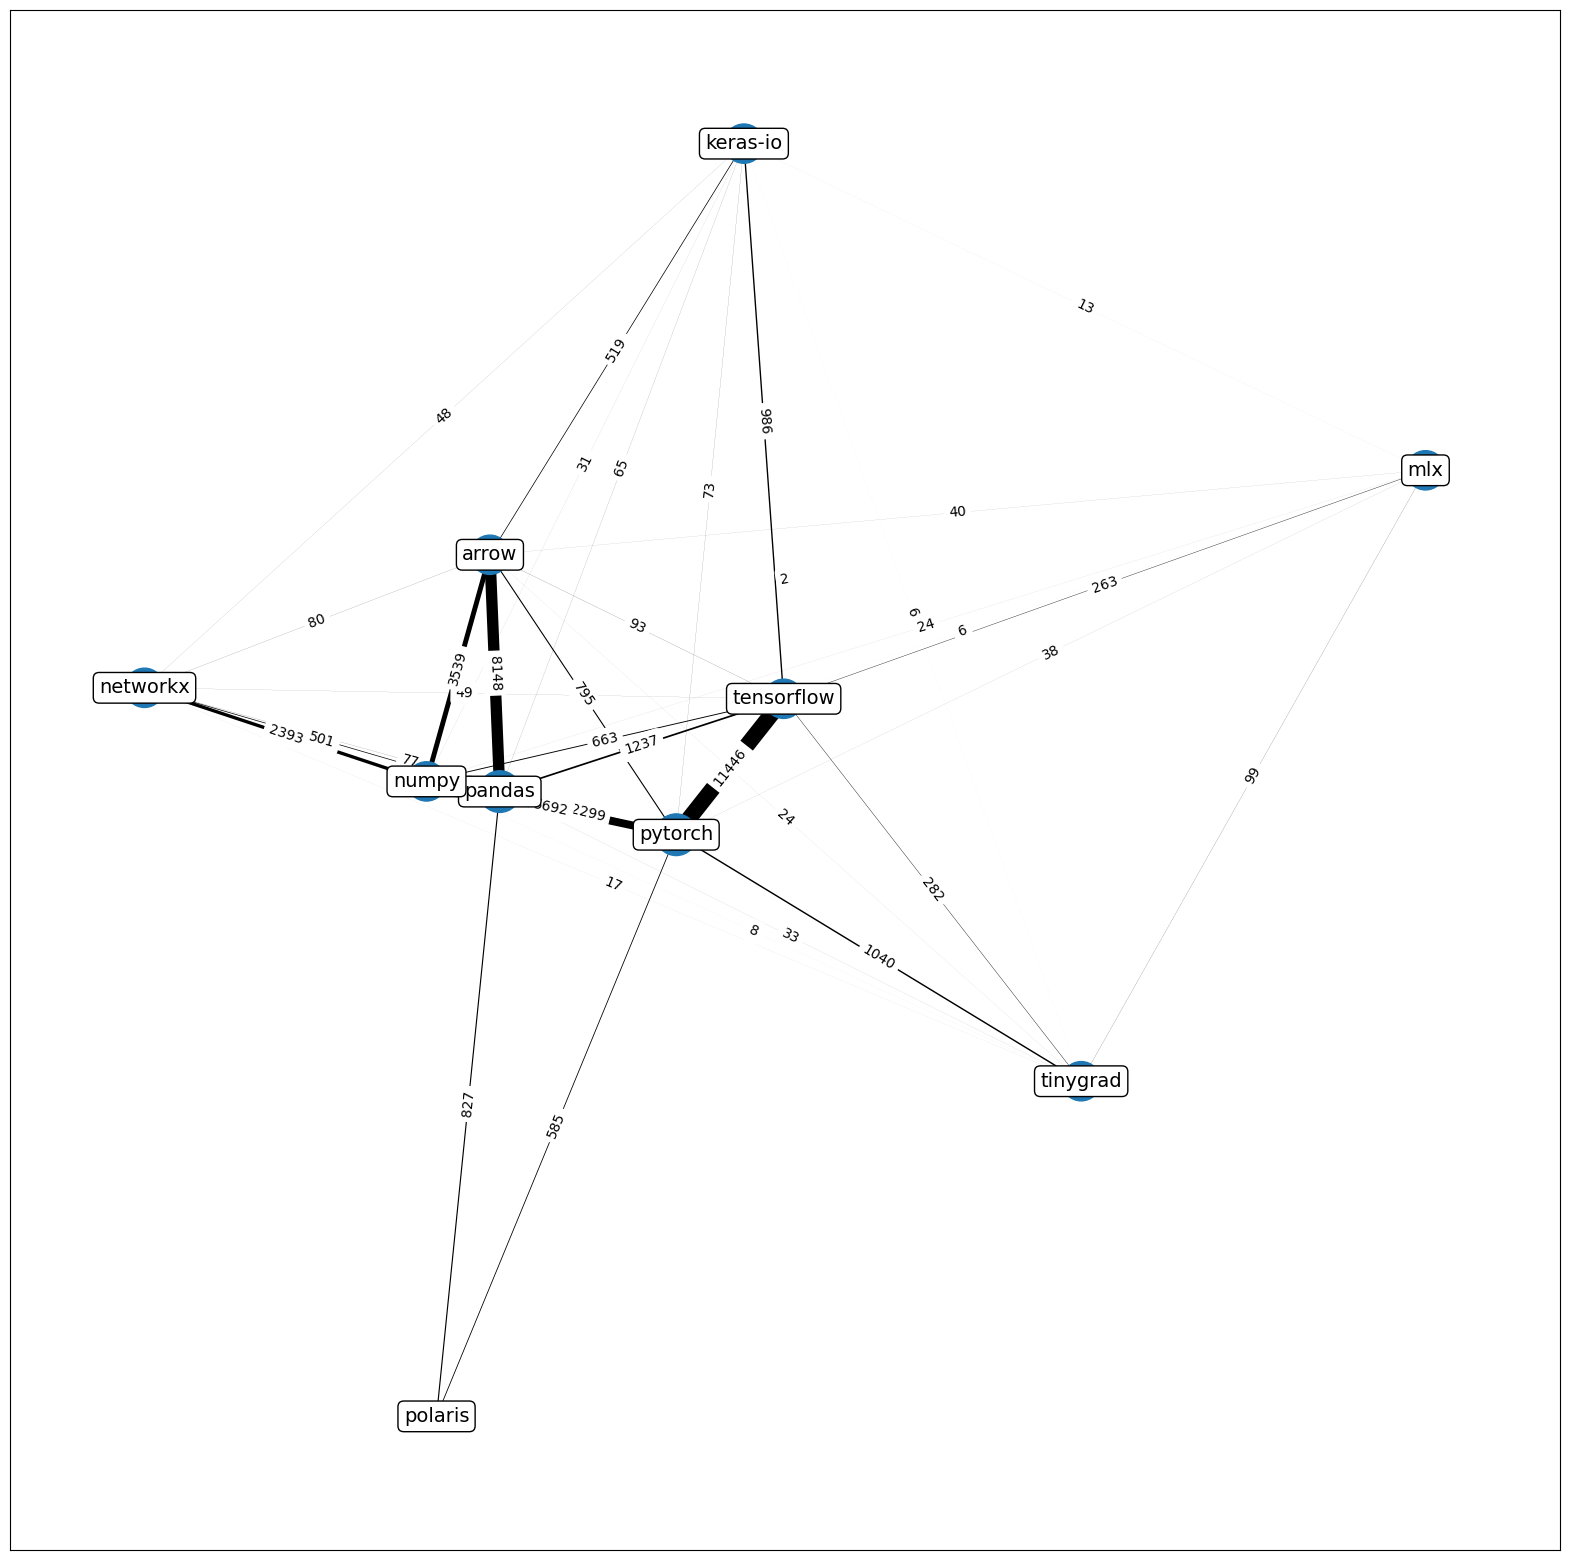

In [19]:
g = nx.Graph()
g.add_weighted_edges_from(res)

# Get positions for all nodes
pos = nx.spring_layout(g)

# Draw the nodes with sizes based on their degree
node_sizes = [nx.degree(g, n) * 100 for n in g.nodes()]

# Draw the edges with widths based on their weight
edge_widths = [g[u][v]['weight'] / 1000 for u, v in g.edges()]

# Create a plot with the specified size
fig, ax = plt.subplots(figsize=(20, 20))

# Draw the nodes and edges with the specified attributes
nx.draw_networkx_nodes(g, pos, node_size=node_sizes, ax=ax)
nx.draw_networkx_edges(g, pos, width=edge_widths, ax=ax)

# Draw the labels with a background box for readability
nx.draw_networkx_labels(g, pos, font_size=14, ax=ax, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Draw edge labels with the number of contributors
edge_labels = {(u, v): g[u][v]['weight'] for u, v in g.edges()}
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_size=10, ax=ax)

# Display the plot
plt.show()

## Converting the above graph to plotly

In [21]:
import plotly.graph_objects as go

# Create a graph and add weighted edges
g = nx.Graph()
g.add_weighted_edges_from(res)

# Get positions for all nodes
pos = nx.spring_layout(g)

# Draw the nodes with sizes based on their degree
node_sizes = [nx.degree(g, n) for n in g.nodes()]

# Extract the x and y coordinates of the nodes
x_nodes = [pos[node][0] for node in g.nodes()]
y_nodes = [pos[node][1] for node in g.nodes()]

# Create the Plotly figure
fig = go.Figure()

# Add each edge as a separate scatter plot with its specific width and hover info
for edge in g.edges(data=True):
    x_edges = [pos[edge[0]][0], pos[edge[1]][0], None]
    y_edges = [pos[edge[0]][1], pos[edge[1]][1], None]
    fig.add_trace(go.Scatter(
        x=x_edges, y=y_edges,
        mode='lines',
        line=dict(width=edge[2]['weight'] / 1000, color='grey'),
        hoverinfo='text',
        text=f'Shared contributors: {edge[2]["weight"]}',
        showlegend=False
    ))

# Add the nodes as a scatter plot
fig.add_trace(go.Scatter(
    x=x_nodes, y=y_nodes,
    mode='markers',
    text=[str(node) for node in g.nodes()],
    marker=dict(size=[size * 5 for size in node_sizes], color='skyblue', line=dict(color='black', width=1)),
    textposition='top center',
    textfont=dict(size=14),
    hoverinfo='text'
))

# Add annotations for the node labels
annotations = []
for node, (x, y) in pos.items():
    annotations.append(
        dict(
            x=x, y=y,
            text=str(node),
            showarrow=False,
            xanchor='center',
            yanchor='top',
            font=dict(color='black', size=12),
            bgcolor='white',
            bordercolor='black',
            borderwidth=1,
            opacity=1.0  # Solid white background
        )
    )

# Update the layout to include annotations
fig.update_layout(
    showlegend=False,  # Disable legend for edges
    annotations=annotations,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    plot_bgcolor='white',
    title='Repositories Network with Shared Contributors'
)

# Show the figure
fig.show()
